This notebook has been created by the author of the Excel workbook ***ExcelentRBF: Interactive Examples of Interpolation with Radial Basis Functions in Microsoft Excel***, [Daniel Owen](https://www.linkedin.com/in/dan-owen), as a companion to the workbook. <br>

It demonstrates the steps outlined in [1] within a Jupyter Notebook format. It is intended for readers interested in understanding the mathematics behind the Spheroidal Covariance basic function used for RBF interpolation in the workbook and accompanying Python code examples.

As with the workbook, this notebook is distributed under the MIT license, allowing readers to freely reuse and share it, provided the license conditions are met. The author kindly requests acknowledgment of the original work and welcomes feedback from those who find it useful or intend to use it in their own projects.

References: <br>
1. https://www.seequent.com/the-spheroidal-family-of-variograms-explained/	<br>


In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

The spheroidal covariance and variogram models were developed by Seequent, primarily for use in RBF interpolants. Seequent wanted an effectively compact spatial function that has linear behaviour near the origin and an asymptotic approach to the sill. This was developed by taking a commonly used family of radial functions and linearizing them near the origin.

That family is the inverse multi-quadric functions, which are also referred to as the generalised Cauchy family in the geostatistics community. They have a shape similar to the more familiar Gaussian model – smooth at the origin, rising rapidly at first, then asymptotically approaching the sill. The shape of the curve therefore has an inflexion point, and it is at this point it makes sense for the linearization to occur.

### Inverse multiquardric of orders
$$C(r) = \big(1 + \frac{r^2}{a^2})^\frac{-m}{2} $$

In [13]:
def inverse_multiquadric_of_orders(radius, order, base_range):
    return (1 + (radius / base_range) ** 2) ** (-order / 2)

To convert the generalised inverse multiquadric covariance to a spheroidal variogram four steps are taken: 

    1. Determine the inflexion point and add the correct linear section between it and the y-axis.
    2. Rescale the values of the function so that the y-intercept is again 1.
    3. Determine the correct scaling for the function argument so a practical range can be defined.
    4. Flip the function so it is in variogram form.

### Inflection point
$$x^*_m = \frac{1}{\sqrt{m + 1}} $$

### Y intercept
$$c_m = 2\Big(\frac{m+2}{m+1})^{-\frac{m}{2} -1} $$

### Linear slope
$$\lambda _m = \frac{m}{2\sqrt{m + 1}} $$

### Range scaling
$$K_m = \sqrt{\frac{11}{20}^\frac{11}{2}c_m ^{-\frac{2}{m}}-1}

In [14]:
def calculate_invmq_inflexion_point(order):
    return 1 / np.sqrt(order + 1)

def calculate_y_intersection(order):
    return 2 * ((order + 2) / (order + 1)) ** ((-order / 2) -1)

def calculate_linear_slope(order):
    return order / (2 * np.sqrt(order + 1))

def calculate_range_scaling(y_int, order):
    return np.sqrt(((11/20) ** (11/2) * y_int) ** (-2 / order) - 1)

Graphs of the inverse multiquadric functions of orders 3, 5, 7 & 9 are shown below.

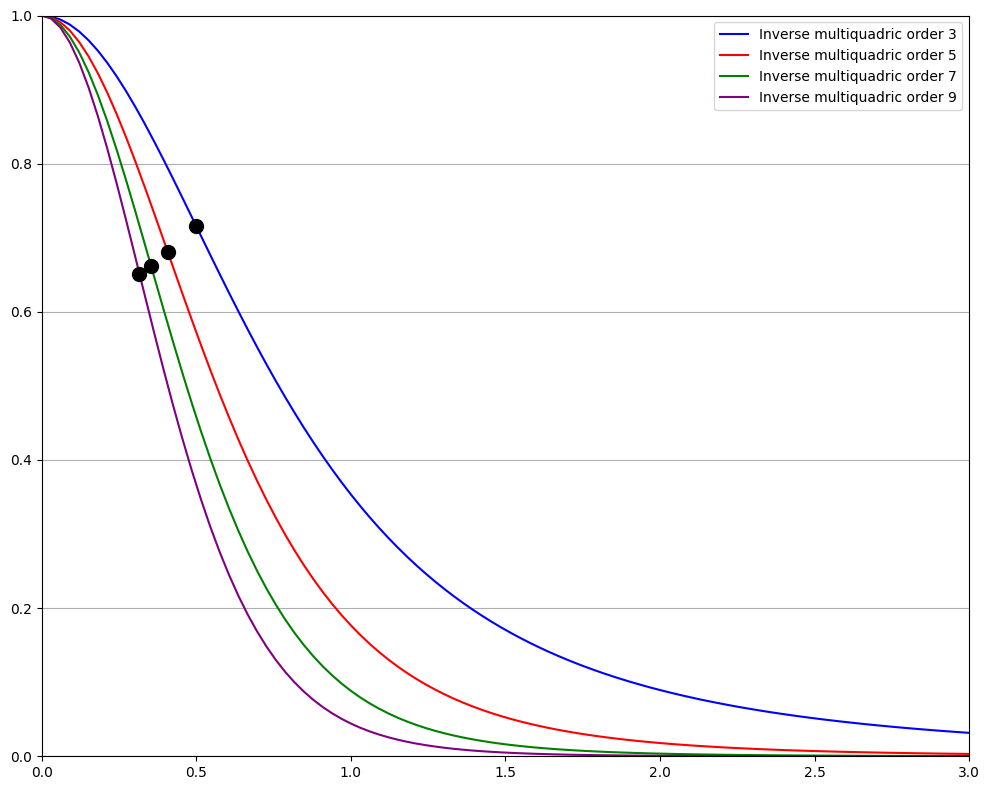

In [15]:
radius = np.linspace(0, 3, 100)

base_range = 1

plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["figure.autolayout"] = True
plt.plot(radius, inverse_multiquadric_of_orders(radius, 3, base_range), color='blue')
plt.plot(radius, inverse_multiquadric_of_orders(radius, 5, base_range), color='red')
plt.plot(radius, inverse_multiquadric_of_orders(radius, 7, base_range), color='green')
plt.plot(radius, inverse_multiquadric_of_orders(radius, 9, base_range), color='purple')
plt.plot(calculate_invmq_inflexion_point(3), inverse_multiquadric_of_orders(calculate_invmq_inflexion_point(3), 3, base_range), color='black', marker='o', markersize=10)
plt.plot(calculate_invmq_inflexion_point(5), inverse_multiquadric_of_orders(calculate_invmq_inflexion_point(5), 5, base_range), color='black', marker='o', markersize=10)
plt.plot(calculate_invmq_inflexion_point(7), inverse_multiquadric_of_orders(calculate_invmq_inflexion_point(7), 7, base_range), color='black', marker='o', markersize=10)
plt.plot(calculate_invmq_inflexion_point(9), inverse_multiquadric_of_orders(calculate_invmq_inflexion_point(9), 9, base_range), color='black', marker='o', markersize=10)
plt.grid(visible=True, axis='y')
plt.axis([0, 3, 0, 1])
plt.legend(['Inverse multiquadric order 3', 'Inverse multiquadric order 5', 'Inverse multiquadric order 7', 'Inverse multiquadric order 9'])
plt.show()

The table of constants for the four orders as per below

In [16]:
m_values = [3, 5, 7, 9]

m_values_dict = dict(zip(m_values, np.arange(4)))

inflexion_points = [calculate_invmq_inflexion_point(m) for m in m_values]
y_intercepts = [calculate_y_intersection(m) for m in m_values]
linear_slopes = [calculate_linear_slope(m) for m in m_values]
range_scalings = [calculate_range_scaling(y_intercepts[idx], m) for idx, m in enumerate(m_values)]

column_names = ['3', '5', '7', '9']
index_names = ['Inflexion point (x*m)', 'Y-intercept (cm)', 'Linear slope (λm)', 'Range scaling (Km)']
df = pd.DataFrame([inflexion_points, y_intercepts, linear_slopes, range_scalings], columns=column_names, index=index_names).rename_axis(index='Order(m)')

df

,3,5,7,9
Order(m),,,,
Inflexion point (x*m),0.500000,0.408248,0.353553,0.316228
Y-intercept (cm),1.144867,1.166047,1.177182,1.184051
Linear slope (λm),0.750000,1.020621,1.237437,1.423025
Range scaling (Km),2.679834,1.582280,1.200868,1.000000


The covariance function, as used in RBF interpolation, can then be defined as:

### Spheroidal covariance
$$\gamma _{m,R} (r) = C(1 - \lambda_mK_m\frac{r}{R}) \text{,   if r }\leq x^*_m K_m^{-1}R$$
$$\gamma _{m,R} (r) = Cc{_m}^{-1}\Big(1 + \Big(K_m\frac{r}{R})^2)^{-\frac{m}{2}} \text{,   if r }\geq x^*_m K_m^{-1}R$$

In [17]:
def spheroidal_covariance(
    radius,
    base_range,
    sill,
    alpha,
    inflexion_point,
    y_intercept,
    linear_slope,
    range_scaling,
):
    return np.where(radius <= inflexion_point * (range_scaling ** -1) * base_range,
        sill * (1 - linear_slope * range_scaling * radius / base_range),
        sill * (y_intercept ** -1) * (1 + (range_scaling * radius / base_range) ** 2) ** (-alpha / 2))

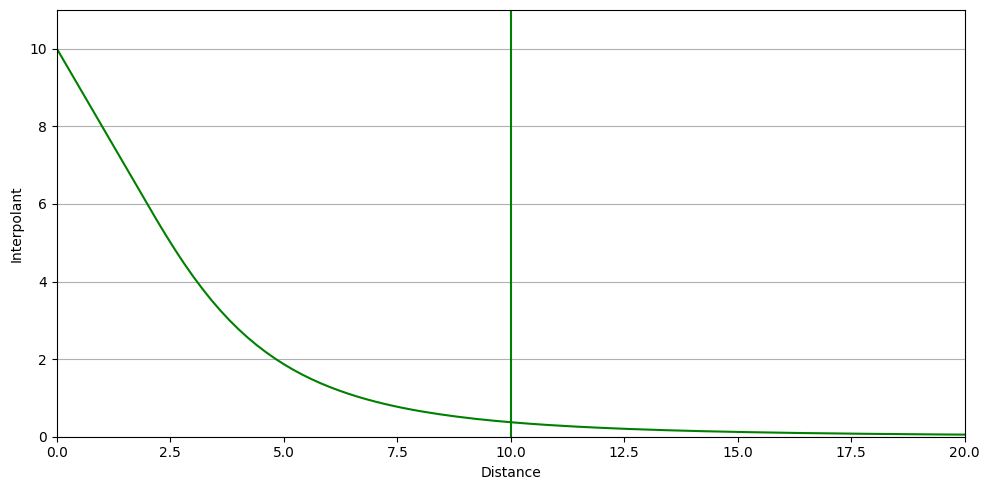

In [18]:
alpha = 3
total_sill = 10
base_range = 10

m_value_dict_val = m_values_dict[alpha]

inflexion_point = inflexion_points[m_value_dict_val]
y_intercept = y_intercepts[m_value_dict_val]
linear_slope = linear_slopes[m_value_dict_val]
range_scaling = range_scalings[m_value_dict_val]

radius = np.linspace(0, 200, 1000)

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plt.plot(radius, spheroidal_covariance(
    radius,
    base_range,
    total_sill,
    alpha,
    inflexion_point,
    y_intercept,
    linear_slope,
    range_scaling,
    ), 
    color='green'
)

plt.axvline(base_range, color='green')
plt.xlabel('Distance')
plt.ylabel('Interpolant')

plt.grid(visible=True, axis='y')
plt.axis([0, 20, 0, 11])
plt.show()

A piecewise expression for the full spheroidal variogram can then be written out:

### Spheroidal variogram
$$\gamma _{m,R} (r) = \lambda_mK_m\frac{r}{R} \text{,   if r }\leq x^*_m K_m^{-1}R$$
$$\gamma _{m,R} (r) = 1-c{_m}^{-1}\Big(1 + \Big(K_m\frac{r}{R})^2)^{-\frac{m}{2}} \text{,   if r }\geq x^*_m K_m^{-1}R$$

In [19]:
def spheroidal_variogram(radius, base_range, order, inflexion_point, y_intercept, linear_slope, range_scaling):
    return np.where(radius <= inflexion_point * range_scaling ** -1 * base_range,
        linear_slope * range_scaling * radius / base_range,
        1 - y_intercept ** -1 * (1 + (range_scaling * radius / base_range) ** 2) ** (-order / 2))

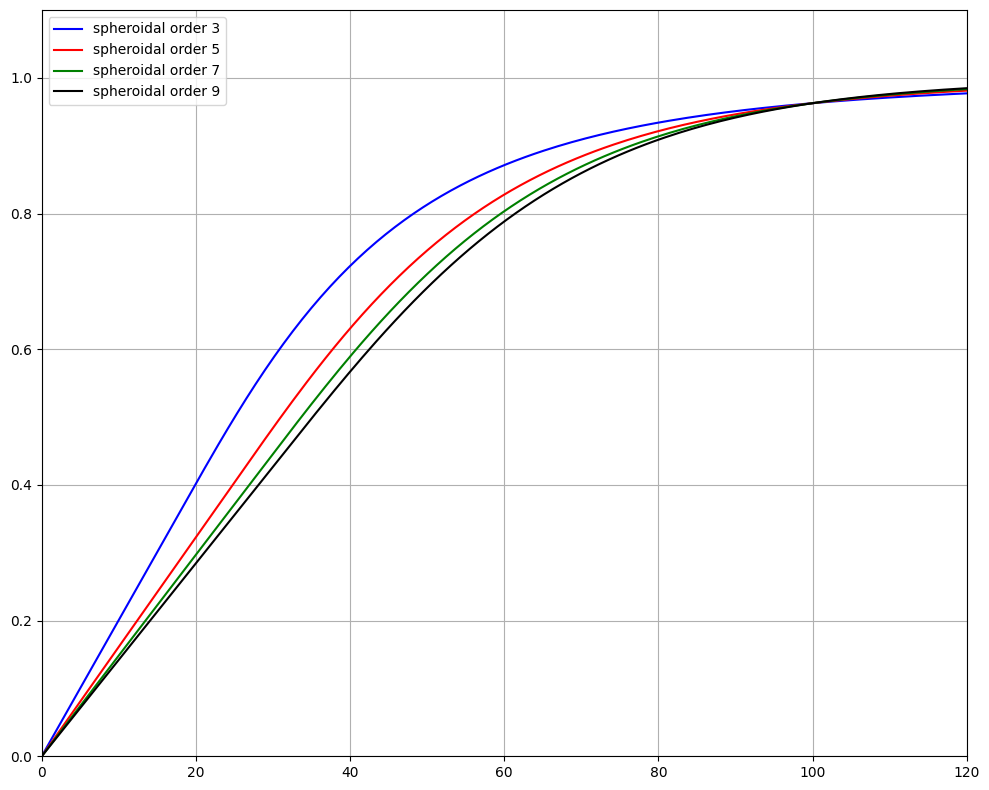

In [20]:
radius = np.linspace(0, 120, 200)

base_range = 100


plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["figure.autolayout"] = True
plt.plot(radius, spheroidal_variogram(radius, base_range, m_values[0], inflexion_points[0], y_intercepts[0], linear_slopes[0], range_scalings[0]), color='blue')
plt.plot(radius, spheroidal_variogram(radius, base_range, m_values[1], inflexion_points[1], y_intercepts[1], linear_slopes[1], range_scalings[1]), color='red')
plt.plot(radius, spheroidal_variogram(radius, base_range, m_values[2], inflexion_points[2], y_intercepts[2], linear_slopes[2], range_scalings[2]), color='green')
plt.plot(radius, spheroidal_variogram(radius, base_range, m_values[3], inflexion_points[3], y_intercepts[3], linear_slopes[3], range_scalings[3]), color='black')
plt.grid(visible=True, axis='both')
plt.axis([0, 120, 0, 1.1])
plt.legend(['spheroidal order 3', 'spheroidal order 5', 'spheroidal order 7', 'spheroidal order 9'])
plt.show()

Adding nugget and sill to the variogram gives the following

In [21]:
def spheroidal_variogram(radius, base_range, order, inflexion_point, y_intercept, linear_slope, range_scaling, nugget, sill):
    return np.where(radius <= inflexion_point * range_scaling ** -1 * base_range,
        nugget + (sill - nugget) * (linear_slope * range_scaling * radius / base_range),
        nugget + (sill - nugget) * (1 - y_intercept ** -1 * (1 + (range_scaling * radius / base_range) ** 2) ** (-order / 2)))

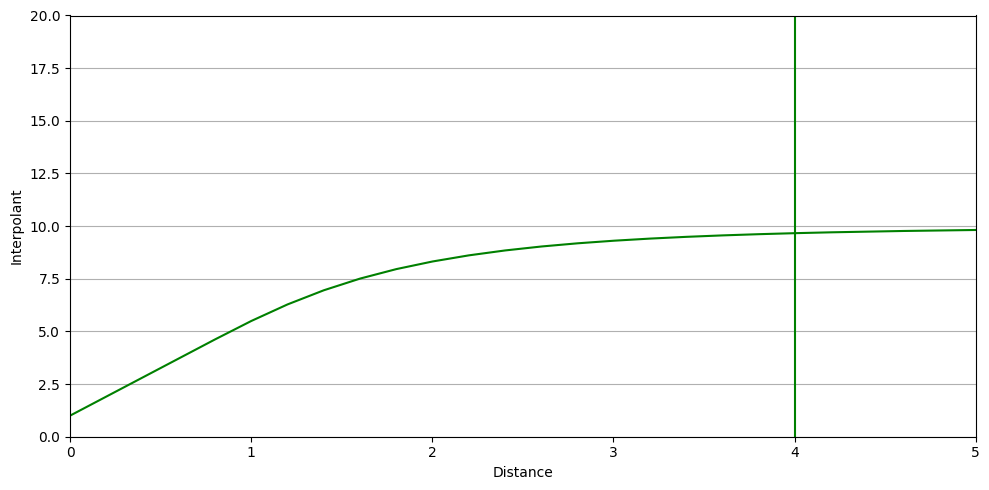

In [22]:
radius = np.linspace(0, 200, 1000)

base_range = 4
nugget = 1
sill = 10
alpha = 3

m_value_dict_val = m_values_dict[alpha]

inflexion_point = inflexion_points[m_value_dict_val]
y_intercept = y_intercepts[m_value_dict_val]
linear_slope = linear_slopes[m_value_dict_val]
range_scaling = range_scalings[m_value_dict_val]

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plt.plot(radius, spheroidal_variogram(radius, base_range, alpha, inflexion_point, y_intercept, linear_slope, range_scaling, nugget, sill), color='green')
plt.axvline(base_range, color='green')
plt.xlabel('Distance')
plt.ylabel('Interpolant')

plt.grid(visible=True, axis='y')
plt.axis([0, 5, 0, 20])
plt.show()